In [1]:
import numpy as np
import starry
import theano
import theano.tensor as tt
import os
import pickle as pkl
import sys
from volcano.time_variable_map import TimeDependentMapSolver
from volcano.optimizers import Adam, NAdam

starry.config.lazy = False

In [2]:
%matplotlib inline
%run notebook_setup.py

## Matrix decomposition model for the time variable map


Given the data consisting of $l=1\dots L$ lightcurves with $T$ data points each and assuming that each light curve was generated from a different map specified with a spherical coefficient vector $\mathbf{y}_l$, the predicted flux for the $l$-th lightcurve is given by

$$
\mathbf{f}_l=\mathbf{A}_l\,\mathbf{y}_l
$$

where $\mathbf{f}_l$ of shape $(T\times 1)$ is the observed flux, $\mathbf{A}_l$  is the design matrix $(T\times N)$ and $\mathbf{y}_l$ is an $(N\times 1) $ vector of SH coefficients.
We can write the predicted flux for all lightcurves simultaneously as

$$
\mathbf{f}=\mathbf{A}\mathbf{y}
$$
where $\mathbf{f}$ is $(TL\times 1)$, $\mathbf{A}$ is a block diagonal matrix of the form

$$
\mathbf{A}=\left(\begin{array}{cccccc}
\mathbf{A}_1 & & & & & \\
& \mathbf{A}_2 & & & \\
& & \mathbf{A}_3 & & \\
& & &  \ddots\\
& & & &  \mathbf{A}_L \\
\end{array}\right)
$$
with shape $(TL\times NL)$ and $\mathbf{y}$ is $(NL\times 1)$.


Insted of fitting for all $N*L$  coefficients simultaneously, we can reduce the number of parameters by treating the map generating any given light curve as a linear combination of $K$ basis maps.
We first reshape the vector $\mathbf{y}$ into a matrix $\mathbf{Y}$ of shape $(N\times L)$. 
We then decompose this matrix as a product of two matrices $\mathbf{P}$ and $\mathbf{Q}$ where the columns of $\mathbf{P}$ define the basis maps and columns of $\mathbf{Q}$ specify the linear coefficients for each lightcruve $l$.

$$
\mathbf{Y}=\mathbf{P}\,\mathbf{Q}
$$

where $P$ is $(N\times K)$ and $Q$ is $(K\times L)$. 
The total number of parameters in our model is then $NK+KL$. 
To compute the predicted flux $\mathbf{f}$, we unroll the matrix $\mathbf{Y}$ into a vector of the same shape
as $\mathbf{y}$, that is, $\mathbf{y}'=\mathrm{vec}\,(\mathbf{Y})$ where $\mathrm{vec}$ denotes the unroll operation by stacking the columns of the $\mathbf{Y}$ matrix.
This unrolled vector  has the following form

$$
\mathbf{y}'=\left(\begin{array}{c}
\sum_kq_{k1}\mathbf{p}_k \\
\sum_kq_{k2}\mathbf{p}_k \\
\vdots \\
\sum_kq_{kL}\mathbf{p}_k
\end{array}\right)
$$

where $\mathbf{p}_k$ is the $k$-th column of the matrix $\mathbf{P}$. 




Although the problem is not linear in both $\mathbf{P}$ and $\mathbf{Q}$ simulataneously, it is linear in each matrix separately. 
Assuming that $\mathbf{P}$ is known, we have 

$$
\mathbf{f}=\mathbf{A}\,\mathbf{P}'\,\mathbf{q}
$$

where $\mathbf{q}\equiv\mathrm{vec}(\mathbf{Q})$ and $\mathbf{P}'$ is an $(NL\times KL)$ matrix constructed by repeating the $\mathbf{P}$ matrix  $L$ times on the diagonal:

$$
\mathbf{P}'=\left(\begin{array}{cccccc}
\mathbf{P} & & & & & \\
& \mathbf{P} & & & \\
& & \mathbf{P} & & \\
& & &  \ddots\\
& & & &  \mathbf{P} \\
\end{array}\right)
$$

Given a prior mean $\boldsymbol{\mu}_{\mathbf{q}}$ and covariance $\boldsymbol{\Sigma}_{\mathbf{q}}$ the analytic solution for the MAP estimate of the posterior is

$$
\widehat{\mathbf{q}}=\boldsymbol{\Sigma}_{\widehat{\mathbf{q}}}\left(\mathbf{P}'^{\top} \mathbf{A}^{\top} \boldsymbol{\Sigma}_{\mathbf{f}}^{-1} \mathbf{f}+\mathbf{\Lambda}_{\mathbf{q}}^{-1} \boldsymbol{\mu}_{\mathbf{q}}\right)
$$

where

$$
\boldsymbol{\Sigma}_{\widehat{\mathbf{q}}}=\left(\mathbf{P}'^{\top} \mathbf{A}^{\top} \boldsymbol{\Sigma}_{\mathbf{f}}^{-1} \mathbf{A} \mathbf{P}'+\mathbf{\Lambda}_{\mathbf{q}}^{-1}\right)^{-1}
$$

If instead we know $\mathbf{Q}$, we have

$$
\mathbf{f}=\mathbf{A}\,\mathbf{Q}'\,\mathbf{p}
$$

where $\mathbf{p}\equiv\mathrm{vec}(\mathbf{P})$ and $\mathbf{Q}'$ is an $(NL\times NK)$ matrix constructed as

$$
\mathbf{Q}'=\left(\begin{array}{c}
q_{11} \mathbf{I}_{N} & q_{21}\mathbf{I}_{N} & \ldots & q_{K1} \mathbf{I}_{N}\\
q_{12} \mathbf{I}_{N} & q_{22}\mathbf{I}_{N} & \ldots & q_{K2} \mathbf{I}_{N}\\
\vdots & \vdots & \ddots & \vdots\\
q_{1L} \mathbf{I}_{N} & q_{2L}\mathbf{I}_{N} & \ldots & q_{KL} \mathbf{I}_{N}\\
\end{array}\right)
$$

where $\mathbf{I}_{N}$ is the identity matrix of size $N$. Given a prior mean $\boldsymbol{\mu}_{\mathbf{p}}$ and covariance $\boldsymbol{\Sigma}_{\mathbf{p}}$ the posterior is analytic as for $\mathbf{q}$.

In [3]:
t_spot = np.load("t_spot.npy")
spot1_amp = np.load("spot1_amp.npy")
spot2_amp = np.load("spot2_amp.npy")

with open("lcs_true.pkl", "rb") as file:
    lcs_true = pkl.load(file)
with open("times.pkl", "rb") as file:
    times = pkl.load(file)
with open("design_matrices.pkl", "rb") as file:
    A_list = pkl.load(file)

sd = 0.02
lcs_obs = [lc + np.random.normal(0, sd, size=(len(lc))) for lc in lcs_true]
lcs_err = [sd * np.ones_like(lc) for lc in lcs_true]

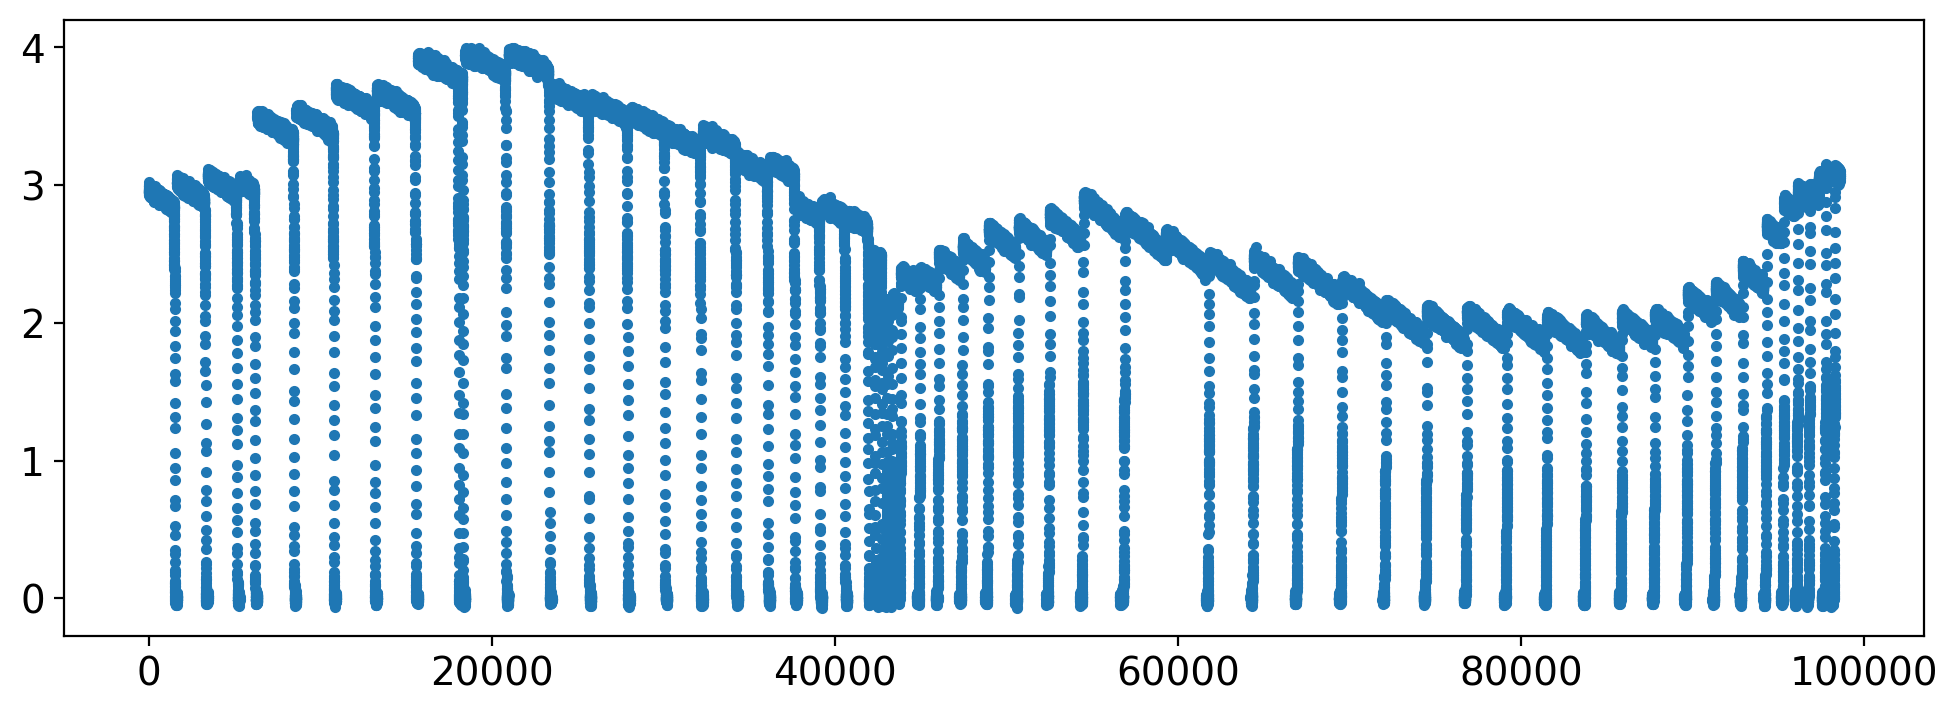

In [4]:
fig, ax = plt.subplots()

flux_obs = np.concatenate(lcs_obs)
ax.plot(flux_obs, "C0.")

In [5]:
Y_true = np.load("Y_true.npy")

# Restrict modeling to a 12th degree map
ycut = int((12 + 1) ** 2)
Y_true = Y_true[:ycut, :]

A_list = [a[:, :ycut] for a in A_list]

# Run SVD on the matrix Y.T
U, S, VT = np.linalg.svd(Y_true.T)

ncomp = 4
P_true = VT.T[:, :ncomp]
Q_true = np.diag(S)[:ncomp, :ncomp] @ U[:, :ncomp].T

for i in [0, 1, 3]:
    P_true[:, i] *= -1
    Q_true[i, :] *= -1

# Check that it's still a valid decomposition
Y_rec = P_true @ Q_true
np.allclose(Y_rec, Y_true)

True

In [6]:
P_true[0, :]

array([3.71805546e-01, 6.24621991e-02, 9.26206840e-01, 3.97321769e-15])

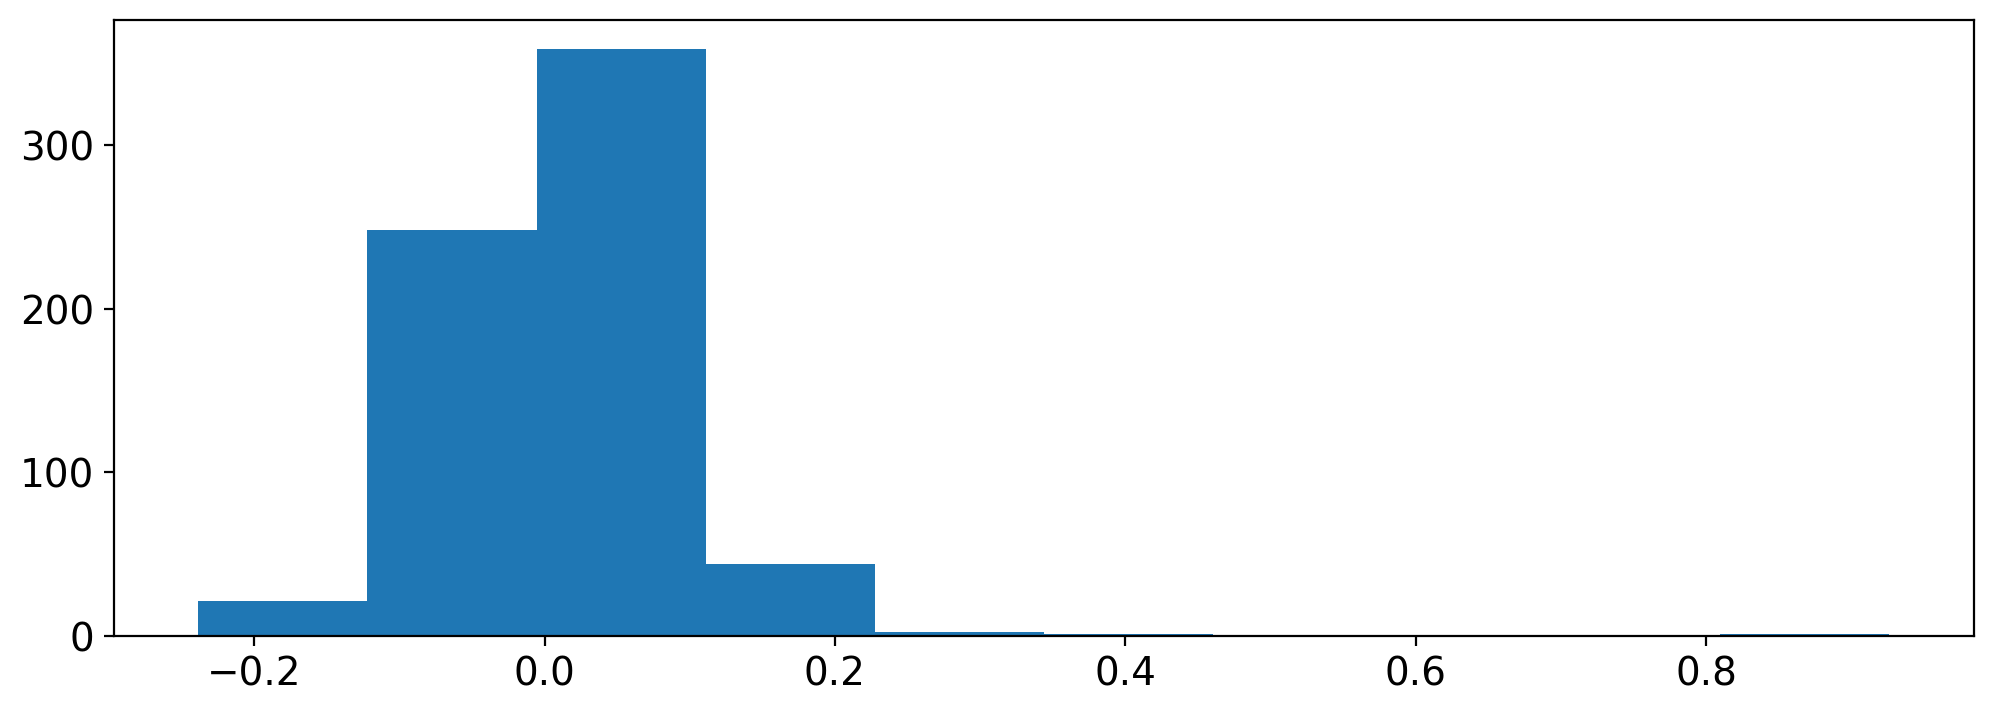

In [7]:
plt.hist(P_true.flatten());

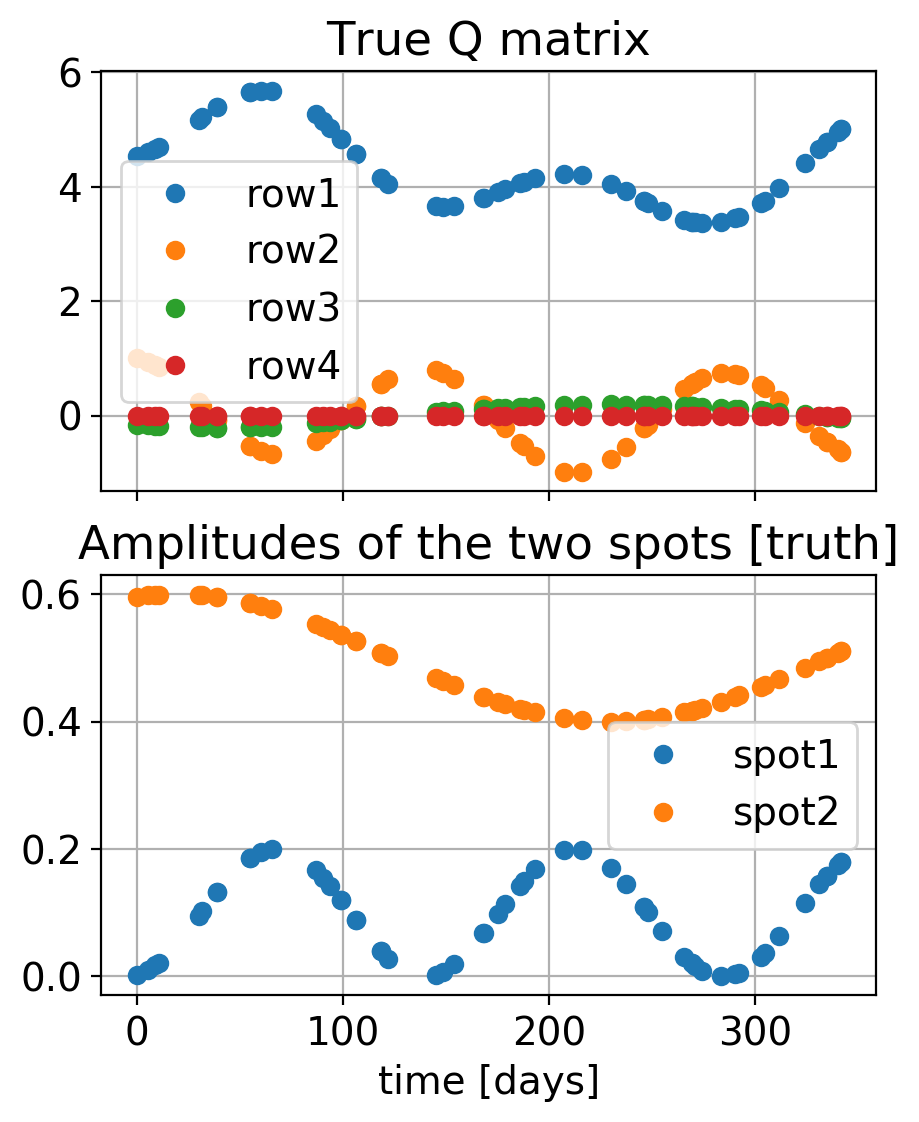

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(5, 6), sharex=True)
ax[0].plot(t_spot - t_spot[0], Q_true[0, :], "C0o", label="row1")
ax[0].plot(t_spot - t_spot[0], Q_true[1, :], "C1o", label="row2")
ax[0].plot(t_spot - t_spot[0], Q_true[2, :], "C2o", label="row3")
ax[0].plot(t_spot - t_spot[0], Q_true[3, :], "C3o", label="row4")

ax[0].legend()
ax[0].set_title("True Q matrix")

ax[1].plot(t_spot - t_spot[0], spot1_amp, "C0o", label="spot1")
ax[1].plot(t_spot - t_spot[0], spot2_amp, "C1o", label="spot2")
ax[1].set_xlabel("time [days]")
ax[1].legend()
ax[1].set_title("Amplitudes of the two spots [truth]")

for a in ax.flatten():
    a.grid()

In [10]:
# Set priors
K = 4
N = np.shape(A_list[0][:, :ycut])[1]
L = len(lcs_true)

# P matrix
P0_mu = np.ones(K)
P1_mu = np.zeros((N - 1, K))
P_mu = np.vstack([P0_mu, P1_mu])

P0_sig = 0.5 * np.ones(K)
P1_sig = 0.01 * np.ones((N - 1, K))
P_sig = np.vstack([P0_sig, P1_sig])

# Q Matrix
Q_mu = np.zeros((K, L))
Q_sig = 2 * np.ones((K, L))
Q_sig_gp = 2 * np.ones(K)
Q_rho_gp = 25.0 * np.ones(K)

# Initialize solver
solver = TimeDependentMapSolver(
    lcs_obs,
    lcs_err,
    A_list,
    K=K,
    tgrid=t_spot,
    P_mu=P_mu,
    P_sig=P_sig,
    Q_mu=Q_mu,
    Q_sig=Q_sig,
    Q_sig_gp=Q_sig_gp,
    Q_rho_gp=Q_rho_gp,
)


# Set initial parameters
P_guess = np.ones((solver.N, solver.K))
P_guess[0, :] = np.array([1.0, 0.8, 0.5, 0.1])
P_guess[1:, :] = 1e-06 * (-1 + 2 * np.random.rand(solver.N - 1, solver.K))
p_guess = P_guess.T.flatten()

Q_guess = -1 + 2 * np.random.rand(solver.K, solver.L)
q_guess = Q_guess.T.flatten()

## Known P matrix

In [17]:
loss, cho_p, cho_q = solver.solve(P=P_true)
loss

64992.431300820535

Residuals RMS:  0.02014118966366298


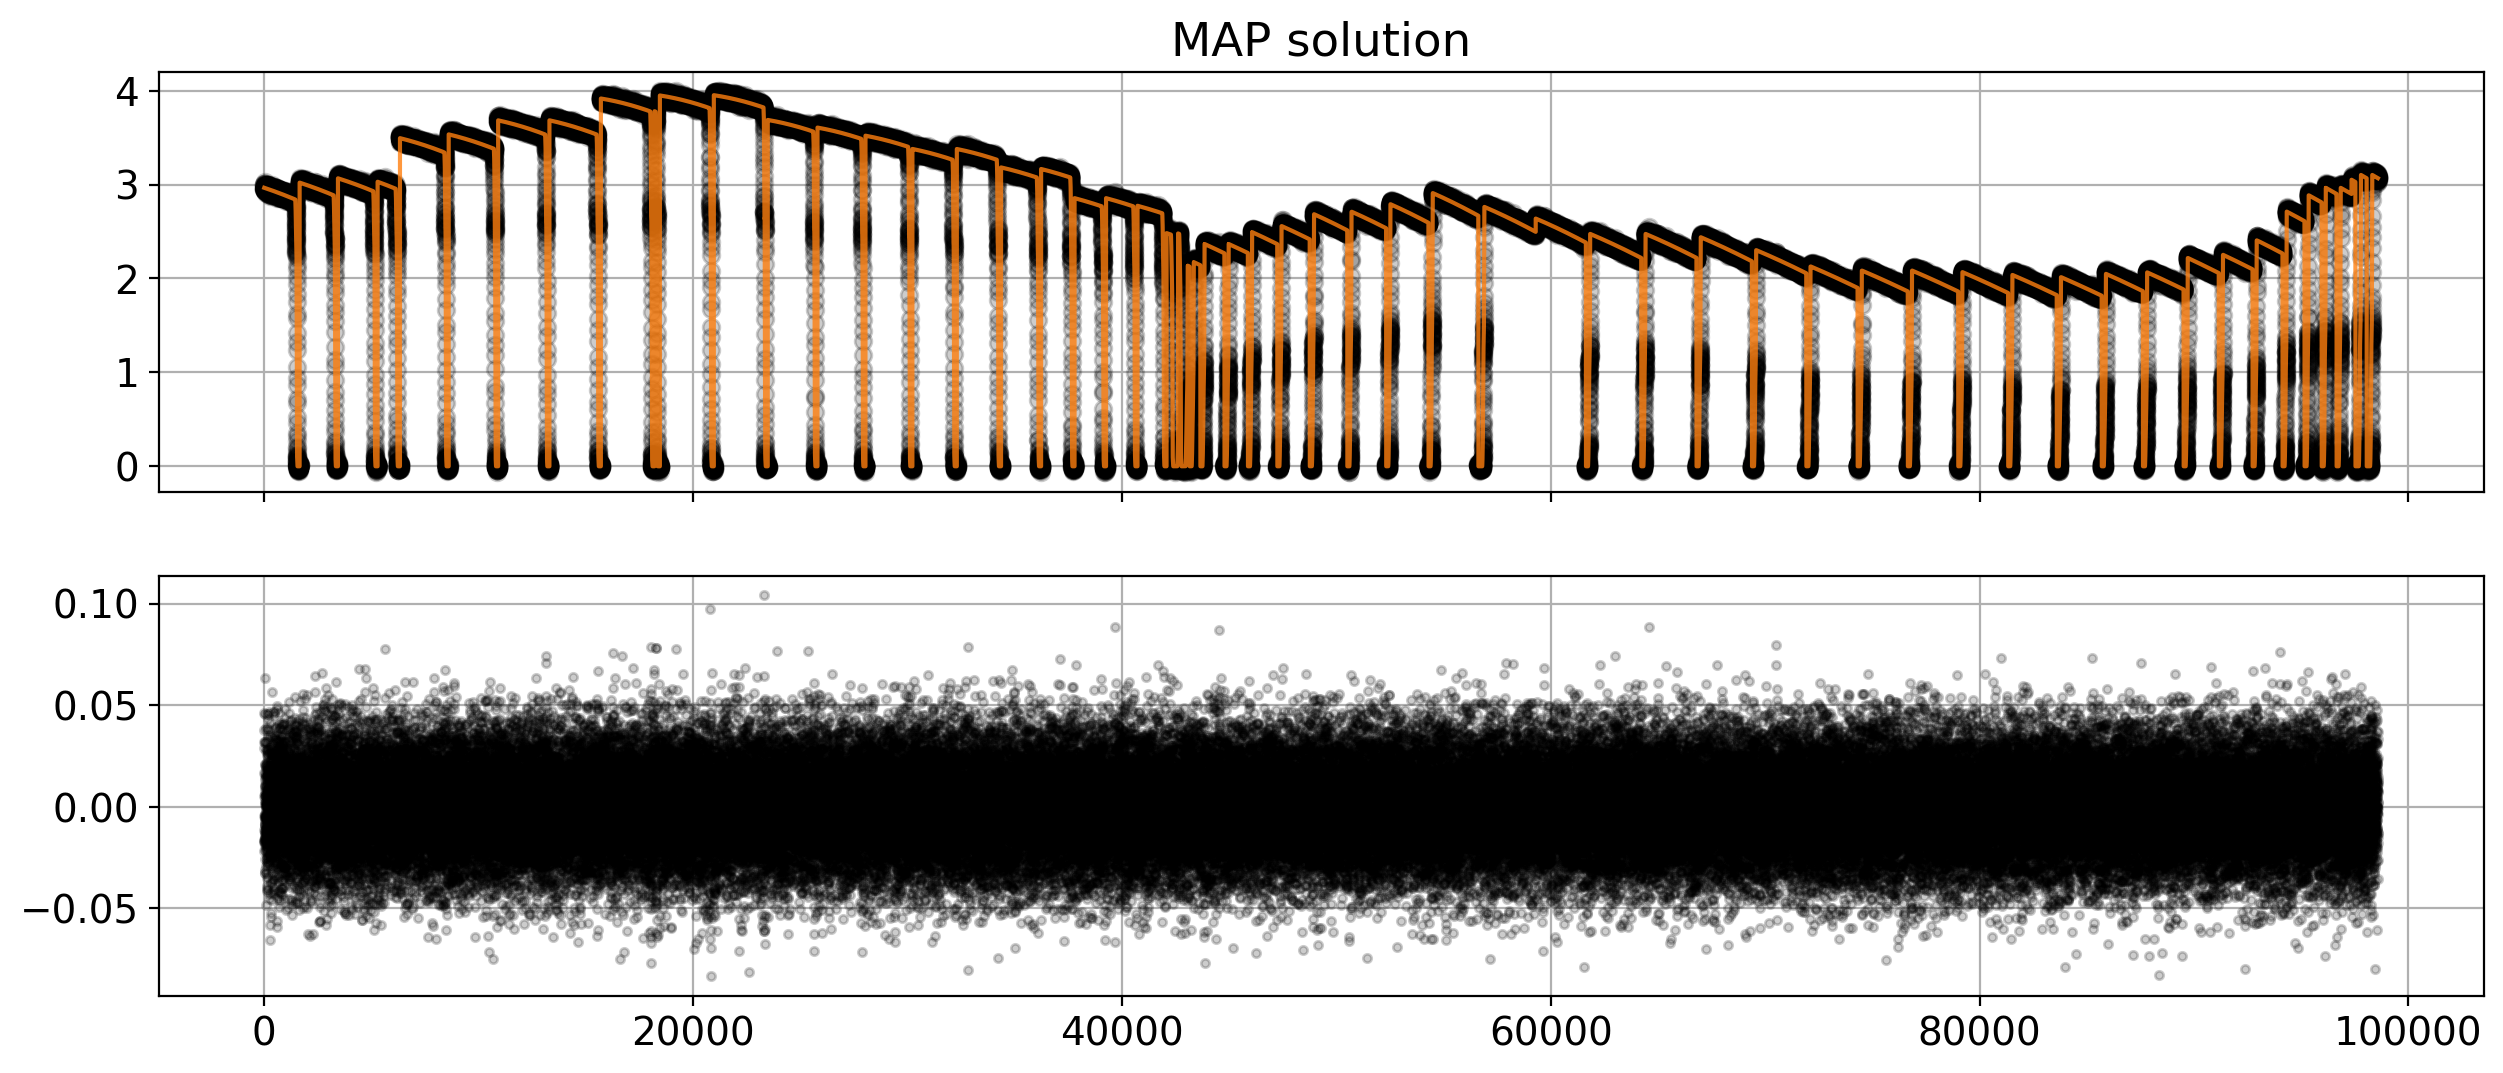

In [18]:
map_flux = solver.model()
map_Q = solver.Q

res = flux_obs - map_flux
res_rms = np.sqrt(np.mean(res ** 2))
print("Residuals RMS: ", res_rms)
# print("loss: ", loss[-1])

fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True,)

ax[0].plot(flux_obs, "ko", alpha=0.2)
ax[0].plot(map_flux, "C1-", alpha=0.8)
ax[0].set_title("MAP solution")

ax[1].plot(res, "k.", alpha=0.2)

for a in ax.flatten():
    a.grid()
#     a.set_xlim(0, 2000)

Text(0.5, 1.0, 'MAP estimate of the Q matrix, diagonal covariance')

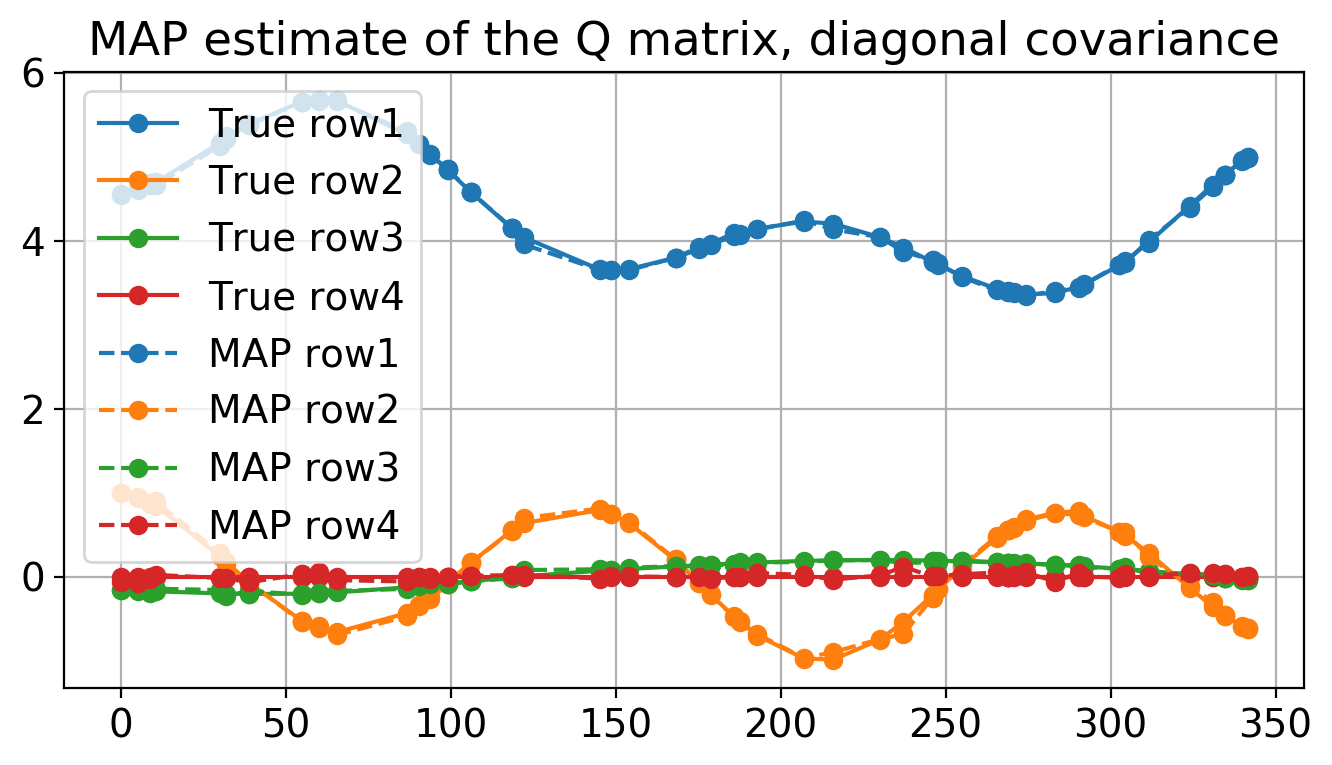

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_spot - t_spot[0], Q_true[0, :], "C0o-", label="True row1")
ax.plot(t_spot - t_spot[0], Q_true[1, :], "C1o-", label="True row2")
ax.plot(t_spot - t_spot[0], Q_true[2, :], "C2o-", label="True row3")
ax.plot(t_spot - t_spot[0], Q_true[3, :], "C3o-", label="True row4")

ax.plot(t_spot - t_spot[0], map_Q[0, :], "C0o--", label="MAP row1")
ax.plot(t_spot - t_spot[0], map_Q[1, :], "C1o--", label="MAP row2")
ax.plot(t_spot - t_spot[0], map_Q[2, :], "C2o--", label="MAP row3")
ax.plot(t_spot - t_spot[0], map_Q[3, :], "C3o--", label="MAP row4")

ax.grid()

ax.legend()
ax.set_title("MAP estimate of the Q matrix, diagonal covariance")

## Known coefficient matrix

In [ ]:
loss, cho_p, cho_q = solver.solve(Q=Q_true)
loss

In [ ]:
map_flux = solver.model()

res = flux_obs - map_flux
res_rms = np.sqrt(np.mean(res ** 2))
print("Residuals RMS: ", res_rms)
print("loss: ", loss)

fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True,)

ax[0].plot(flux_obs, "ko", alpha=0.2)
ax[0].plot(map_flux, "C1-", alpha=0.8)
ax[0].set_title("MAP solution")

ax[1].plot(res, "k.", alpha=0.2)

for a in ax.flatten():
    a.grid()
#     a.set_xlim(0, 5000)

In [ ]:
# Plot basis maps
fig, ax = plt.subplots(4, 1, figsize=(6, 15))

map_P = solver.P

for i in range(4):
    map = starry.Map(ydeg=12)
    map.amp = map_P[0, i]
    map[1:, :] = map_P[1:, i] / map_P[0, i]
    img = map.render(projection="rect")
    extent = (-180, 180, -90, 90)
    ax[i].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax[i].set_xticks([-180, -90, 0, 90, 180])
    im = ax[i].imshow(
        img, origin="lower", extent=extent, cmap="plasma", vmin=-1, vmax=1.5
    )
    ax[i].set_title(f"Component {i + 1}")

    fig.colorbar(im, ax=ax[i])

## Both matrices unknown

In [20]:
# Evaluate loss at truth
solver.P = P_true
solver.Q = Q_true
solver._compute_cov()
loss_true = solver.loss()
print("loss at truth: ", loss_true)

loss at truth:  65093.19344108165


In [21]:
loss, cho_p, cho_q = solver.solve(
    P_guess=P_guess,
    Q_guess=Q_guess,
    niter=200,
    T=10.0,
    dlogT=-0.02,
    optimizer="NAdam",
    lr=1e-07,
)

  0%|          | 0/51 [00:00<?, ?it/s]

Running bi-linear solver...


100%|██████████| 51/51 [07:13<00:00,  8.50s/it]


Running non-linear solver...


100%|██████████| 200/200 [00:21<00:00,  9.51it/s]


In [22]:
print(loss[-1])

50679.50043267182


In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(np.log(loss))
ax.set_ylabel("ln [loss]")
ax.set_ylim(10, 15)
ax.set_xlabel("Number of iterations")
ax.grid()
# ax.set_xlim(0, 1000)

In [ ]:
map_flux = solver.model()

res = flux_obs - map_flux
res_rms = np.sqrt(np.mean(res ** 2))
print("Residuals RMS: ", res_rms)
print("final loss: ", loss[-1])

fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True,)

ax[0].plot(flux_obs, "ko", alpha=0.2)
ax[0].plot(map_flux, "C1-", alpha=0.8)
ax[0].set_title("MAP solution")

ax[1].plot(res, "k.", alpha=0.2)

for a in ax.flatten():
    a.grid()
#     a.set_xlim(0, 5000)

In [ ]:
fig, ax = plt.subplots(8, 6, figsize=(12, 15), sharex=True)

map_P = solver.P
map_Q = solver.Q
map_Y = map_P @ map_Q

for i, a in enumerate(ax.flatten()):
    a.plot(t_spot, Y_true[i, :], "C0-")
    a.plot(t_spot, map_Y[i, :], "C1-")
    a.set_title(f"Coeff {i}")
    a.axis("off")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_spot - t_spot[0], Q_true[0, :], "C0o-", label="True row1")
ax.plot(t_spot - t_spot[0], Q_true[1, :], "C1o-", label="True row2")
ax.plot(t_spot - t_spot[0], Q_true[2, :], "C2o-", label="True row3")
ax.plot(t_spot - t_spot[0], Q_true[3, :], "C3o-", label="True row4")

ax.plot(t_spot - t_spot[0], map_Q[0, :], "C0o--", label="MAP row1")
ax.plot(t_spot - t_spot[0], map_Q[1, :], "C1o--", label="MAP row2")
ax.plot(t_spot - t_spot[0], map_Q[2, :], "C2o--", label="MAP row3")
ax.plot(t_spot - t_spot[0], map_Q[3, :], "C3o--", label="MAP row4")

ax.grid()

ax.legend()
ax.set_title("MAP estimate of the Q matrix, diagonal covariance")

In [ ]:
# Plot basis maps
fig, ax = plt.subplots(4, 1, figsize=(7, 15))

for i in range(4):
    map = starry.Map(ydeg=12)
    map.amp = map_P[0, i]
    map[1:, :] = map_P[1:, i] / map_P[0, i]
    img = map.render(projection="rect")
    extent = (-180, 180, -90, 90)
    ax[i].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax[i].set_xticks(np.arange(-180, 210, 30))
    im = ax[i].imshow(
        img, origin="lower", extent=extent, cmap="plasma", vmin=-0.5, vmax=0.6
    )
    ax[i].set_title(f"Component {i + 1}")
    fig.colorbar(im, ax=ax[i])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

idx = 39

map.reset()
map.amp = map_Y[0, idx]
map[1:, :] = map_Y[1:, idx] / map_Y[0, idx]
img = map.render(projection="rect")

map.reset()
map.amp = Y_true[0, idx]
map[1:, :] = Y_true[1:, idx] / Y_true[0, idx]
img_true = map.render(projection="rect")


extent = (-180, 180, -90, 90)

ax[0].imshow(img, origin="lower", extent=extent, cmap="plasma", vmin=0.0, vmax=4.0)
ax[1].imshow(img_true, origin="lower", extent=extent, cmap="plasma", vmin=0.0, vmax=4.0)

for a in ax.flatten():
    a.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    a.set_ylabel("Latitutde [deg]")

ax[1].set_xticks(np.arange(-180, 210, 30))

ax[0].set_title(f"MAP estimate for light curve {idx + 1}")
ax[1].set_title(f"True map for light curve {idx + 1}")

ax[1].set_xlabel("Longitude [deg]")

## Complete solution with a GP prior on Q and a starry process prior on P

In [ ]:
# Set priors
K = 4
N = np.shape(A_list[0][:, :ycut])[1]
L = len(lcs_true)

# P matrix
P0_sig = 0.5 * np.ones(K)


P0_mu = np.ones(K)
P1_mu = np.zeros((N - 1, K))
P_mu = np.vstack([P0_mu, P1_mu])
Q_mu = np.zeros((K, L))


# Initialize solver
solver = TimeDependentMapSolver(
    lcs_obs,
    lcs_err,
    A_list,
    K=K,
    tgrid=t_spot,
    sp_P0_sig=P0_sig,
    Q_mu=Q_mu,
    Q_sig_gp=2 * np.ones(K),
    Q_rho_gp=25.0 * np.ones(K),
    sp_alpha=2.0 * np.ones(K),
    sp_beta=0.5 * np.ones(K),
    sp_ln_size_mu=-3.0 * np.ones(K),
    sp_ln_size_sig=0.0 * np.ones(K),
    sp_ln_amp_mu=-2.3 * np.ones(K),
    sp_ln_amp_sig=0.0 * np.ones(K),
    sp_sign=-1.0 * np.ones(K),
)


# Set initial parameters
P_guess = np.ones((solver.N, solver.K))
P_guess[0, :] = np.array([1.0, 0.8, 0.5, 0.1])
P_guess[1:, :] = 1e-06 * (-1 + 2 * np.random.rand(solver.N - 1, solver.K))
p_guess = P_guess.T.flatten()

Q_guess = -1 + 2 * np.random.rand(solver.K, solver.L)
q_guess = Q_guess.T.flatten()

In [ ]:
loss, cho_p, cho_q = solver.solve(
    P_guess=P_guess,
    Q_guess=Q_guess,
    niter=1000,
    T=10.0,
    dlogT=-0.02,
    optimizer="NAdam",
    lr=1e-07,
)

In [ ]:
map_flux = solver.model()

res = flux_obs - map_flux
res_rms = np.sqrt(np.mean(res ** 2))
print("Residuals RMS: ", res_rms)
print("final loss: ", loss[-1])

fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True,)

ax[0].plot(flux_obs, "ko", alpha=0.2)
ax[0].plot(map_flux, "C1-", alpha=0.8)
ax[0].set_title("MAP solution")

ax[1].plot(res, "k.", alpha=0.2)

for a in ax.flatten():
    a.grid()
#     a.set_xlim(0, 5000)

In [ ]:
# Plot basis maps
fig, ax = plt.subplots(4, 1, figsize=(7, 15))

for i in range(4):
    map = starry.Map(ydeg=12)
    map.amp = solver.P[0, i]
    map[1:, :] = solver.P[1:, i] / solver.P[0, i]
    img = map.render(projection="rect")
    extent = (-180, 180, -90, 90)
    ax[i].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax[i].set_xticks(np.arange(-180, 210, 30))
    im = ax[i].imshow(
        img, origin="lower", extent=extent, cmap="plasma", vmin=-0.5, vmax=0.6
    )
    ax[i].set_title(f"Component {i + 1}")
    fig.colorbar(im, ax=ax[i])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

idx = 39

map.reset()
map.amp = solver.Y[0, idx]
map[1:, :] = solver.Y[1:, idx] / solver.Y[0, idx]
img = map.render(projection="rect")

map.reset()
map.amp = Y_true[0, idx]
map[1:, :] = Y_true[1:, idx] / Y_true[0, idx]
img_true = map.render(projection="rect")


extent = (-180, 180, -90, 90)

ax[0].imshow(img, origin="lower", extent=extent, cmap="plasma", vmin=0.0, vmax=4.0)
ax[1].imshow(img_true, origin="lower", extent=extent, cmap="plasma", vmin=0.0, vmax=4.0)

for a in ax.flatten():
    a.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    a.set_ylabel("Latitutde [deg]")

ax[1].set_xticks(np.arange(-180, 210, 30))

ax[0].set_title(f"MAP estimate for light curve {idx + 1}")
ax[1].set_title(f"True map for light curve {idx + 1}")

ax[1].set_xlabel("Longitude [deg]")